# Imports

In [3]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os

# Date
import datetime as datetime
from sodapy import Socrata

## API Call: NYC Parking Tickets

In [4]:
# Export sodapy token

socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'nc67-uf89'
socrata_token = os.environ.get("SODAPY_APPTOKEN")

# Make request

client = Socrata(socrata_domain, socrata_token)
print("Domain: {domain:}\nSession: {session:}\nURI Prefix: {uri_prefix:}")

In [6]:
#Identify all columns available in dataset

metadata = client.get_metadata(socrata_dataset_identifier)
[x['name'] for x in metadata['columns']]

['Plate',
 'State',
 'License Type',
 'Summons Number',
 'Issue Date',
 'Violation Time',
 'Violation',
 'Judgment Entry Date',
 'Fine Amount',
 'Penalty Amount',
 'Interest Amount',
 'Reduction Amount',
 'Payment Amount',
 'Amount Due',
 'Precinct',
 'County',
 'Issuing Agency',
 'Violation Status',
 'Summons Image']

In [7]:
#Pull API. Limit number is based on previously identified as the number of street parking violations from the total 50m rows of data

results = client.get(socrata_dataset_identifier,\
                     select=('Plate, State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,\
                     Precinct,County'),\
                     where ="(violation='NO PARKING-STREET CLEANING')",\
                     limit=6766400)

results_df = pd.DataFrame.from_dict(results)
results_df.head()

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County
0,HTE1892,NY,03/06/2020,09:13A,65,65,0,044,BX
1,556749R,NJ,03/06/2020,09:11A,65,65,0,044,BX
2,99940ML,NY,03/06/2020,09:09A,65,65,0,044,BX
3,99867ML,NY,03/06/2020,09:08A,65,65,0,044,BX
4,JNR5500,NY,03/06/2020,08:27A,65,65,0,044,BX


In [8]:
results_df.shape

(6766400, 9)

# Data Analysis

In [9]:
# Create a copy of the dataframe to preserve the content of the API export during cleaning

violation_df = results_df.copy()
violation_df.head()

In [11]:
violation_df['time_issued'] = (violation_df['Issue_Date'] + ' ' + violation_df['Violation_Time'])
violation_df.head()

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,time_issued
0,HTE1892,NY,03/06/2020,09:13A,65,65,0,044,BX,03/06/2020 09:13A
1,556749R,NJ,03/06/2020,09:11A,65,65,0,044,BX,03/06/2020 09:11A
2,99940ML,NY,03/06/2020,09:09A,65,65,0,044,BX,03/06/2020 09:09A
3,99867ML,NY,03/06/2020,09:08A,65,65,0,044,BX,03/06/2020 09:08A
4,JNR5500,NY,03/06/2020,08:27A,65,65,0,044,BX,03/06/2020 08:27A


In [12]:
violation_df['time_issued']=pd.to_datetime(violation_df['time_issued'], errors='coerce')
violation_df.head(10)

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,time_issued
0,HTE1892,NY,03/06/2020,09:13A,65,65,0,044,BX,2020-03-06 09:13:00
1,556749R,NJ,03/06/2020,09:11A,65,65,0,044,BX,2020-03-06 09:11:00
2,99940ML,NY,03/06/2020,09:09A,65,65,0,044,BX,2020-03-06 09:09:00
3,99867ML,NY,03/06/2020,09:08A,65,65,0,044,BX,2020-03-06 09:08:00
4,JNR5500,NY,03/06/2020,08:27A,65,65,0,044,BX,2020-03-06 08:27:00
5,HXH3134,NY,03/06/2020,08:25A,65,65,0,044,BX,2020-03-06 08:25:00
6,JHA9913,NY,03/06/2020,07:44A,65,65,0,046,BX,2020-03-06 07:44:00
7,1350082,CO,03/05/2020,08:51A,65,65,0,048,BX,2020-03-05 08:51:00
8,LFJ1104,PA,03/05/2020,08:44A,65,65,0,048,BX,2020-03-05 08:44:00
9,JMA1428,NY,03/05/2020,08:40A,65,65,0,048,BX,2020-03-05 08:40:00


In [13]:
violation_df.drop(['Violation_Time', 'Issue_Date'], axis=1, inplace=True)
violation_df.loc[violation_df['time_issued']=='NaT', 'time_issued']= np.nan 
violation_df.dropna(inplace = True)

In [14]:
violation_df['Precinct'] = violation_df['Precinct'].astype(float)
violation_df['Fine_Amount'] = violation_df['Fine_Amount'].astype(float)
violation_df['Amount_Due'] = violation_df['Amount_Due'].astype(float)
violation_df['Payment_Amount'] = violation_df['Amount_Due'].astype(float)

In [15]:
violation_df.loc[violation_df['Precinct']>123, 'Precinct']= np.nan 
violation_df.dropna(inplace = True)

In [16]:
violation_df.shape

(6742721, 8)

In [17]:
violation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6742721 entries, 0 to 6766399
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Plate           object        
 1   State           object        
 2   Fine_Amount     float64       
 3   Amount_Due      float64       
 4   Payment_Amount  float64       
 5   Precinct        float64       
 6   County          object        
 7   time_issued     datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 463.0+ MB


In [18]:
violation_df.loc[violation_df['time_issued']>'2019-12-31 12:00:00', 'time_issued']= np.nan
violation_df.loc[violation_df['time_issued']<'2017-01-01 12:00:00', 'time_issued']= np.nan
violation_df.dropna(inplace = True)

In [19]:
min(violation_df['time_issued'])

Timestamp('2017-01-02 00:00:00')

In [20]:
max(violation_df['time_issued'])

Timestamp('2019-12-31 12:00:00')

In [21]:
violation_df.shape

(5012643, 8)

In [22]:
# move cols

violation_df = violation_df[[ 'Plate','time_issued', 'Fine_Amount', 'Amount_Due', 'Payment_Amount',
       'Precinct', 'County', 'State']]
violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,State
9985,HXW1523,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,K,NY
9986,HGV9494,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,K,NY
9987,HNR8751,2019-12-30 09:12:00,45.0,45.0,45.0,66.0,K,NY
9988,HVW1204,2019-12-30 09:09:00,45.0,75.0,75.0,66.0,K,NY
9989,522904R,2019-12-30 09:03:00,45.0,55.0,55.0,66.0,K,NJ


In [23]:
violation_df['weekday'] = violation_df['time_issued'].dt.weekday
county_dummies = pd.get_dummies(violation_df['County'], prefix='County')
weekday_dummies = pd.get_dummies(violation_df['weekday'], prefix='weekday')
violation_df = pd.concat([violation_df, county_dummies, weekday_dummies], axis=1)
violation_df.drop(columns =['County','weekday'], inplace=True)
violation_df.columns

Index(['Plate', 'time_issued', 'Fine_Amount', 'Amount_Due', 'Payment_Amount',
       'Precinct', 'State', 'County_BX', 'County_K', 'County_NY', 'County_Q',
       'County_R', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [24]:
violation_df.rename(columns={'County_BX':'Bronx', 'County_K':'Brooklyn', \
                             'County_NY':'Manhattan', 'County_Q':'Queens', \
                             'County_R':'Staten_Island'}, inplace=True)

In [25]:
#Clean this up later

violation_df.loc[violation_df['State'] =='NY', 'State']= 1

out_of_state = {'FL':0, 'NJ':0, 'MI':0, 'RI':0, 'PA':0, 'VA':0, 'ME':0, 'CT':0, 'NC':0, 'AL':0,
       'TX':0, 'IL':0, 'MA':0, 'WI':0, 'IN':0, 'GV':0, 'NH':0, 'OH':0, '99':0, 'AZ':0, 'CA':0,
       'SC':0, 'LA':0, 'GA':0, 'VT':0, 'OR':0, 'MD':0, 'SD':0, 'MO':0, 'DE':0, 'WV':0, 'OK':0,
       'ON':0, 'CO':0, 'AR':0, 'AK':0, 'QB':0, 'WA':0, 'MT':0, 'NV':0, 'UT':0, 'TN':0, 'DC':0, 'YT':0,
       'NE':0, 'KY':0, 'IA':0, 'MN':0, 'ID':0, 'KS':0, 'ND':0, 'MS':0, 'NM':0, 'WY':0, 'HI':0, 'NF':0,
       'MX':0, 'DP':0, 'AB':0, 'NS':0, 'BC':0, 'PR':0, 'NB':0, 'FO':0, 'MB':0, 'PE':0, 'SK':0, 'NT':0}

violation_df['State'].replace(out_of_state, inplace = True)
violation_df['State'].value_counts()

1    3809327
0    1203316
Name: State, dtype: int64

In [26]:
violation_df.rename(columns={'Precinct':'precinct'}, inplace=True)
violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
9985,HXW1523,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9986,HGV9494,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9987,HNR8751,2019-12-30 09:12:00,45.0,45.0,45.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9988,HVW1204,2019-12-30 09:09:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9989,522904R,2019-12-30 09:03:00,45.0,55.0,55.0,66.0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [27]:
zero_dict = {0: np.nan}
violation_df['precinct'].replace(zero_dict, inplace = True)
violation_df.dropna(inplace = True)

violation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5010657 entries, 9985 to 6763920
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Plate           object        
 1   time_issued     datetime64[ns]
 2   Fine_Amount     float64       
 3   Amount_Due      float64       
 4   Payment_Amount  float64       
 5   precinct        float64       
 6   State           int64         
 7   Bronx           uint8         
 8   Brooklyn        uint8         
 9   Manhattan       uint8         
 10  Queens          uint8         
 11  Staten_Island   uint8         
 12  weekday_0       uint8         
 13  weekday_1       uint8         
 14  weekday_2       uint8         
 15  weekday_3       uint8         
 16  weekday_4       uint8         
 17  weekday_5       uint8         
 18  weekday_6       uint8         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1), uint8(12)
memory usage: 363.2+ MB


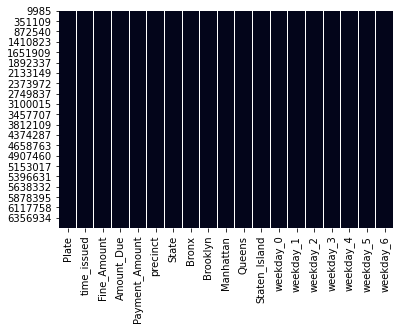

In [28]:
sns.heatmap(violation_df.isnull(), cbar=False)

In [29]:
violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
9985,HXW1523,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9986,HGV9494,2019-12-30 09:16:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9987,HNR8751,2019-12-30 09:12:00,45.0,45.0,45.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9988,HVW1204,2019-12-30 09:09:00,45.0,75.0,75.0,66.0,1,0,1,0,0,0,1,0,0,0,0,0,0
9989,522904R,2019-12-30 09:03:00,45.0,55.0,55.0,66.0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [30]:
violation_df.to_csv('ParkingTickets_Data_Raw.csv')